Nama : M. Iqbal Baskoro

##                      PROJECT 3 : VOICE RECOGNITION
##              Klasifikasi Maksud Ucapan (Intent Classification)


### Data dan Algoritma Understanding

#### TUJUAN :
Membangun model yang dapat mengenali dan
mengklasifikasikan maksud (intent) dari sebuah rekaman suara.

#### DATASET:
https://huggingface.co/datasets/PolyAI/minds14

#### <Strong>Data Field</Strong>

| Nama Kolom | Tipe Data | Keterangan |
|:----------:|:---------:|:----------:|
|`path `| String | Path to the audio file |
|`audio `| Dict | Audio object including loaded audio array, sampling rate and path ot audio |
|`transcription `| String | Transcription of the audio file |
|`english_transcription `| String | English transcription of the audio file |
|`intent_class `| Integer | Class id of intent |
|`lang_id `| Integer | Id of language |

#### <strong>Pengolahan Dataset</strong>
-`Pembagian Dataset` = <strong>Training</strong>(80%) dan <strong>Test</strong>(20%) <br>
-`Audio Preprocessing` = <strong>Resampling</strong>, Audio diseragamkan ke sampling rate 16000 Hz <br>


#### MODEL :


### Model Training & Evaluation

In [1]:
%pip install datasets transformers evaluate torch torchaudio scikit-learn matplotlib seaborn librosa tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import torchcodec
from IPython.display import display, Audio
from sklearn.metrics import confusion_matrix, classification_report
from datasets import load_dataset, Dataset, DatasetDict, Features, Value, ClassLabel, Sequence
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer
import evaluate
from tqdm.auto import tqdm

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Stay tuned...


C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("Memuat dataset PolyAI/minds14...")
minds_dataset = load_dataset("PolyAI/minds14", "all")
print("\nDataset berhasil dimuat.")

# Bagi dataset
train_test_split = minds_dataset["train"].train_test_split(train_size=0.8, seed=42)
test_valid_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)

minds = DatasetDict({
    'train': train_test_split['train'],
    'validation': test_valid_split['train'],
    'test': test_valid_split['test']
})
print("\nStruktur dataset setelah dibagi:")
print(minds)

Memuat dataset PolyAI/minds14...


Using the latest cached version of the dataset since PolyAI/minds14 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'all' at C:\Users\SUWAAAN\.cache\huggingface\datasets\PolyAI___minds14\all\1.0.0\7bdf27fccad4efc6da7c00f739d96bfa0d25a7a85f2244755a73c865f70182bc (last modified on Wed Jul 16 13:11:30 2025).



Dataset berhasil dimuat.

Struktur dataset setelah dibagi:
DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 6534
    })
    validation: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 817
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 817
    })
})


In [4]:
# Siapkan label
intents = minds["train"].features["intent_class"].names
label2id = {label: i for i, label in enumerate(intents)}
id2label = {i: label for i, label in enumerate(intents)}
num_labels = len(intents)
print(f"\nJumlah intent: {num_labels}")


Jumlah intent: 14


In [6]:
def get_duration_from_path(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)  # Memuat audio dengan sampling rate asli
        duration = librosa.get_duration(y=audio, sr=sr)  # Menghitung durasi
        return duration
    except Exception as e:
        print(f"Error memproses {file_path}: {e}")
        return 0.0

durations = minds['train'].map(
    lambda x: {'duration': get_duration_from_path(x['path'])},
    num_proc=4  # Parallel processing
)

# Visualize the distribution of audio durations
plt.figure(figsize=(12, 6))
plt.hist(durations['duration'], bins=50, edgecolor='black')
plt.title('Distribusi Durasi Audio dalam Dataset', fontsize=16)
plt.xlabel('Durasi (detik)', fontsize=12)
plt.ylabel('Jumlah Sampel', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Map (num_proc=4):   0%|          | 0/6534 [00:01<?, ? examples/s]


NameError: name 'get_duration_from_path' is not defined

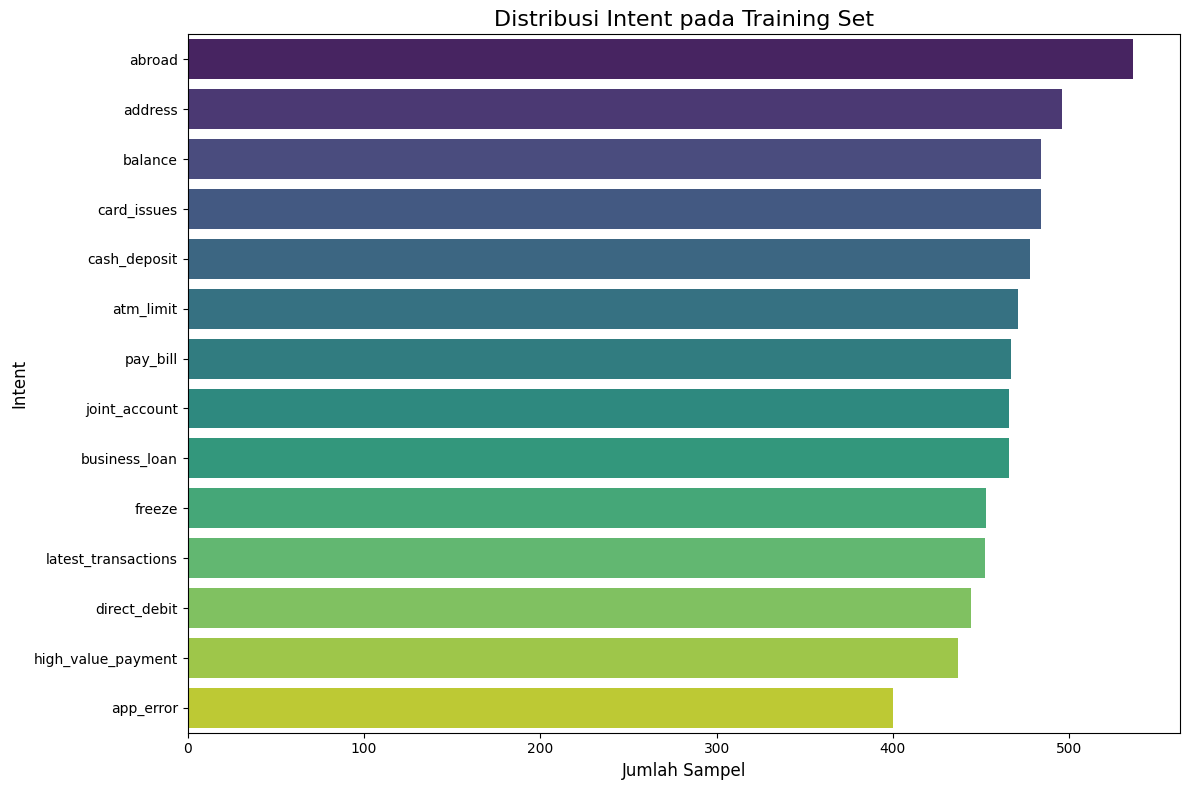

In [ ]:
# Mengambil nama intent dari fitur dataset
intent_names = minds['train'].features['intent_class'].names

# Menghitung frekuensi setiap intent
intent_counts = pd.Series(minds['train']['intent_class']).value_counts()
intent_count_labels = [intent_names[i] for i in intent_counts.index]

# Visualisasi distribusi intent
plt.figure(figsize=(12, 8))
sns.barplot(x=intent_counts.values, y=intent_count_labels, palette='viridis', hue=intent_count_labels, dodge=False)
plt.title('Distribusi Intent pada Training Set', fontsize=16)
plt.xlabel('Jumlah Sampel', fontsize=12)
plt.ylabel('Intent', fontsize=12)
plt.legend([],[], frameon=False) # Sembunyikan legenda
plt.tight_layout()
plt.show()

Teks Transkripsi: 'Bonjour je souhaite déposer une grosse somme d'argent en cash sur mon compte courant veuillez m'indiquer la meilleure la meilleure manière de procéder'
Intent: cash_deposit
Sampling Rate: 16000 Hz


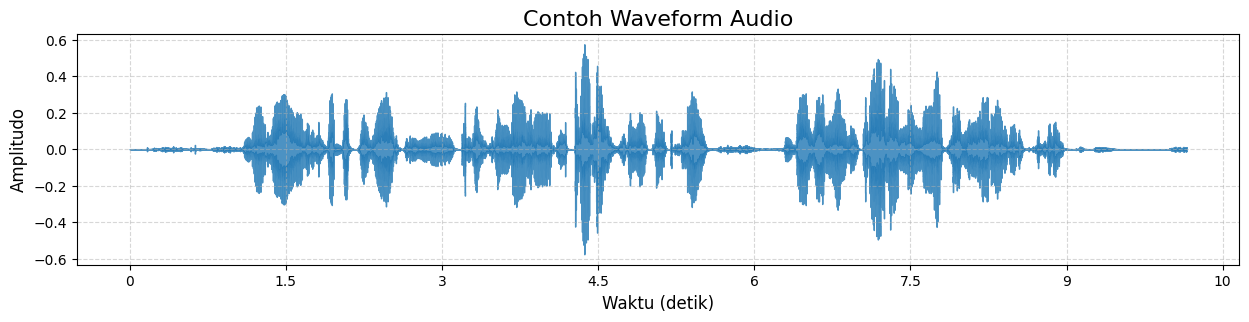

Memutar audio sampel:


In [ ]:
# Ambil satu contoh acak dari dataset training
sample = minds["train"][50] # Anda bisa ganti indeksnya
audio_data = sample["audio"]

# Muat array audio dan sampling rate
audio_array = np.array(audio_data["array"], dtype=np.float32)
sr = audio_data["sampling_rate"]

print(f"Teks Transkripsi: '{sample['transcription']}'")
print(f"Intent: {id2label[sample['intent_class']]}")
print(f"Sampling Rate Asli: {sr} Hz")

# Visualisasi waveform
plt.figure(figsize=(15, 3))
librosa.display.waveshow(audio_array, sr=sr, alpha=0.8)
plt.title('Contoh Waveform Audio', fontsize=16)
plt.xlabel('Waktu (detik)', fontsize=12)
plt.ylabel('Amplitudo', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Memutar audio
print("Memutar audio sampel:")
display(Audio(data=audio_array, rate=sr))

In [ ]:
%pip install torchcodec

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# ### Pra-pemrosesan Data dengan AutoFeatureExtractor
# Memuat feature extractor dari model pre-trained
model_checkpoint = "facebook/wav2vec2-base"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

# Sampling rate yang dibutuhkan oleh model adalah 16kHz
target_sampling_rate = feature_extractor.sampling_rate
print(f"Sampling rate yang dibutuhkan model: {target_sampling_rate} Hz")

# Durasi maksimal 4 detik untuk membatasi ukuran input
max_duration = 4.0 

def preprocess_function(examples):
    # Ekstrak array audio dari setiap sampel
    audio_arrays = [x["array"] for x in examples["audio"]]
    
    # Proses audio dengan feature extractor. 
    # Ini akan menangani resampling ke target_sampling_rate, padding, dan truncation.
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=target_sampling_rate,
        max_length=int(target_sampling_rate * max_duration),
        truncation=True,
        padding='max_length'
    )
    
    # Tambahkan label ke input
    inputs["labels"] = examples["intent_class"]
    return inputs

# Terapkan fungsi preprocessing ke seluruh dataset
print("\nMemulai pra-pemrosesan dataset...")
remove_columns = ["audio", "transcription", "english_transcription", "lang_id", 'path']
encoded_minds = {}
for split in minds:
    encoded_minds[split] = minds[split].map(
        preprocess_function, 
        remove_columns=remove_columns, 
        batched=True,
        batch_size=100 # Proses dalam batch untuk efisiensi
    )
print("Pra-pemrosesan selesai.")

print("\nStruktur dataset setelah pra-pemrosesan:")
print(encoded_minds)

C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(



Memulai pra-pemrosesan dan ekstraksi fitur (secara manual)...
Memproses split: train...


 82%|████████▏ | 5332/6534 [00:11<00:02, 448.99it/s]


KeyboardInterrupt: 

In [ ]:
# Memuat model pre-trained dengan head klasifikasi yang disesuaikan
print("\nMemuat model Wav2Vec2 untuk klasifikasi...")
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)
print("Model berhasil dimuat.")

# Memuat metrik akurasi untuk evaluasi
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """Menghitung akurasi selama evaluasi."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Mendefinisikan argumen untuk training
training_args = TrainingArguments(
    output_dir="./results-voice-recognition",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5, # Jumlah epoch bisa ditambah jika hasilnya kurang memuaskan
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Membuat instance Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_minds["train"],
    eval_dataset=encoded_minds["validation"],
    tokenizer=feature_extractor, # Feature extractor digunakan sebagai tokenizer
    compute_metrics=compute_metrics,
)

# Memulai training
print("\nMemulai proses training model...")
trainer.train()
print("Training selesai.")

In [ ]:
# Lakukan prediksi pada test set yang belum pernah dilihat model
print("\nMengevaluasi model pada test set...")
test_results = trainer.predict(encoded_minds["test"])
print("Evaluasi selesai.")

# Dapatkan prediksi dan label sebenarnya
y_preds = np.argmax(test_results.predictions, axis=1)
y_true = test_results.label_ids

# Dapatkan nama-nama intent untuk laporan
intent_names = minds["train"].features["intent_class"].names

# Cetak laporan klasifikasi (precision, recall, f1-score)
print("\nLaporan Klasifikasi:")
print(classification_report(y_true, y_preds, target_names=intent_names, digits=3))

# Buat dan visualisasikan confusion matrix
print("\nMembuat Confusion Matrix...")
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=intent_names, yticklabels=intent_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Prediksi Label', fontsize=12)
plt.ylabel('Label Sebenarnya', fontsize=12)
plt.show()